# CORD-19 solution

Overall experience can be visualized using website we created for CORD-19 challenge at http://cord19.covid19insights.org/

We also imported all the code from github to kaggle as /kaggle/input/code-repo-for-all-code/

# Approach

We attempted to solve the CORD-19 research challenge by applying two main techniques - 

 1. Reducing the **search space !**
 2. Surface documents based on **similarity rankings**
 3. Use Sentence vector embeddings from tensorflow hub
 4. Complete code at Public Github repository with Apache License v2: https://github.com/covid19-cord19/cord19
 5. Step by step process to run the code can be found at : https://github.com/covid19-cord19/cord19/blob/master/solr_intercepts/README.md

## Reducing search space

Our solution uses a search engine to crawl and ingest all the 138,000 scholarly articles including 68,000 research articles and associated relevant metadata attributes with the document - title, abstract and body. We selected Solr with Lucene indexes as the search engine to help us reduce 138k search space to top 100 documents using tf-idf and idf boosting technique.

### Solr as Search Engine - 

Solr provides many advanced searching capabilities. Here’s how Solr performs the following operations in a sequence to search for a document:

 1. **Indexing** : As the Cord19 files are already in JSON format, we can upload them directly to Solr by calling the index request handler (or simply index handler). 

 2. **Querying** : We can search for various terms such as keywords, images or geolocation data, for instance. When you send a query, Solr processes it with a query request handles (or simply query handler) that works similarly to the index handler, only that is used to return documents from the Solr index instead of uploading them.  


```python
def send_for_solr_indexing(doc, env):
    """
     Sends the text document for indexing
     params:
     doc: text document to be indexed
     env: dev or prod
    """
    if(env):
        solr = pysolr.Solr(config["solr_url"+"_"+env], timeout=10)
    else:
        solr = pysolr.Solr(config["solr_url"], timeout=10)
   
    solr.add(doc)
    solr.optimize()  

```

**Code snippet**
To fine tune Solr search to return right subset of documents, we need to identify the right query terms to boost.  This is done by using term’s inverse document frequency (idf), which decreases the weight for commonly used words and increases the weight for words that are not used very much in a collection of documents.
During the document ingestion process we generate the idf dictionary for the entire document corpus that serves as a look up to identify boost parameter values.


```python
def process_request(self, term):
    """
     Process request for re-computed inverse document frequency so we can boost query terms.
     
     params:
     term: new terms to be added
    """
    self.dictionary = self.load_dictionary("./dictionary", "dictIDF.txt")
    term_weights = {}
    for term in terms:
        try:
            if term in self.dictionary:
                term_weights[term]  = self.dictionary[term]
            else:
                term_weights[term]  = 5.0
        except:
            pass
    solr_query = ' '.join(['{0}:{3}^{4} {1}:{3}^{4} {2}:{3}^{4}'.format("body", "abstract", "title", term, term_weights[term]) for term in terms])
    print(solr_query)
    return solr_query
```

 3. **Ranking the Results** : As it matches indexed documents to a query, Solr ranks the results by their relevance score – the most relevant hits appear at the top of the matched documents
 
 
Overall approach in architecture diagram

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/covid19_2.png" width="1500px"/>


<br>
<br>
<br>
<br>

## Sentence vector embeddings from tensorflow hub

Semantic similarity is a measure of the degree to which two pieces of text carry the same meaning. This is broadly useful in obtaining good coverage over the numerous ways that a thought can be expressed using language without needing to manually enumerate them.

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/sentence_embedding.png" width="800px"/>

We use Tensorflow hub module for universal-sentence-encoder, The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector.

One of the example use case:

```python
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/3")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])["outputs"]

print(embeddings)

# The following are example embedding output of 512 dimensions per sentence
# Embedding for: The quick brown fox jumps over the lazy dog.
# [-0.03133016 -0.06338634 -0.01607501, ...]
# Embedding for: I am a sentence for which I would like to get its embedding.
# [0.05080863 -0.0165243   0.01573782, ...]

```
Typical model pipeline for sentence-encoder in google based flow looks like: 

Sentence Semantic Similarity solution

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Tf-hub_sentence_semantic_similarity.png" width="800px"/>

## Document similarity 

Document similarity (or distance between documents) is a one of the central themes in Information Retrieval. How humans usually define how similar are documents? Usually documents treated as similar if they are semantically close and describe similar concepts. 
Classical approach from computational linguistics is to measure similarity based on the content overlap between documents. For this we will represent documents as sentence embeddings (vectors) , so each document will be a sparse vector. And define measure of overlap as angle between vectors

Similarity (doc1, doc2) = Cos(θ) = (doc1 . doc2) / (||doc1|| . ||doc2||)

	Where doc1 and doc2 are task and document embedding vectors

The resulting similarity ranges from −1 meaning exactly opposite, to 1 meaning exactly the same, with 0 indicating orthogonality or decorrelation, while in-between values indicate intermediate similarity or dissimilarity.

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/cosine_similarity.png" width="800px"/>

Subset of documents (result from Solr search) is used to similarity check and rank them in descending order of similarity score

```python

    for task in range(0, len(taskEmbeddings)):
         j = 1
         for doc in range(0, len(docsEmbeddings)):
             cos_sim = cosine_similarity(taskEmbeddings[task].reshape(1, -1), docsEmbeddings[doc].reshape(1, -1))
             score.append(round(cos_sim[0][0], 3))
             print('Cosine similarity: Task {0} Document {1} = {2}'.format(i, j, round(cos_sim[0][0], 3)))
             j = j + 1
         i = i + 1
    documentDF['score'] = score
    documentDF.sort_values(by=['score'], ascending=False, inplace=True)

```

### How to make it work on your local

ALL THE INSTRUCTIONS ARE IN README.md file at : 
  http://github.com/covid19-cord19/cord19/tree/master/solr_intercepts
  
  

# Code for Search api 

 Code for this search api at http://cord19.covid19insights.org:4004/search  is checked in **public github repo with Apache v2 license: https://github.com/covid19-cord19/cord19** and also imported here inside :
 
>  All code - "/kaggle/input/code-repo-for-all-code/"

>  Flask Server code - "/kaggle/input/code-repo-for-all-code/app.py"

## Flask server implementation which takes user questions and tasks:
      - cleans and pre-process for stop words 
      
      - lookups from precomputed idf from "/kaggle/input/code-repo-for-all-code/dictionary/dictIDF.txt"
          - code for computing idf is at "/kaggle/input/code-repo-for-all-code/document_search/document_search_engine.py"
          
      - sends the query to solr server - which can be running 
          - assumption here is that all the 130k research artciles are pre-ingested to Solr
          -  Code file for solr_ingestion : /kaggle/input/code-repo-for-all-code/solr_intercepts/solr_ingestor.py
              -  It reads all the articles ./data and send it to solr which needs a core creation before ingestion, script file for core -ingestion is at : /kaggle/input/code-repo-for-all-code/solr_intercepts/core_creation.sh
              
      - Gets the results from Solr
      
      - Computes sentence vector embedding
          - from tensorflow hub sentence vector embedding model
          
      - Runs cosine distance computation to identify similarity score
      
      - Returns results in most relevant order
      
## Visualization - 
The calls to apis were working before the submission but for some reason stopped working now. Since we could not visualize all this experience within the notebook here - we have integrated this code on 1 machine on AWS server: 34.223.223.77 and also created a url for this host cord19.covid19insights.org - the whole experience can be visualized by browsing through this website at : http://cord19.covid19insights.org
 

 


In [ ]:
import requests
host = "34.223.223.77"
url = "http://cord19.covid19insights.org:4004/search"
request_headers = {"content-type": "application/json"}

```python
request_data = {
    "task": "What do we know about vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients ",
    "subtask": "Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication."
}
# post data to url
response = requests.post(url, json=request_data, headers=request_headers) 
#store response
data = response.json()[0]


print(data['title'], data['body'], data['abstract'], data['url'])

```

We were able to see the results before but now these apis are erroring because of connection error, but here is web result ( top 2) from website http://cord19.covid19insights.org )

Web result ( top 1 ) from website: 

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Task_sub_task1.png" width="1200px"/>

```python
request_data = {
    "task": "What do we know about vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients ",
    "subtask": "Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients."
}
# post data to url
response = requests.post(url, json=request_data, headers=request_headers) 
#store response
data = response.json()[0]


print(data['title'], data['body'], data['abstract'], data['url'])
```

Web result ( top 2) from website: 

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Task_sub_task2.png" width="1200px"/>

```python

request_data = {
    "task": "What do we know about vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients ",
    "subtask": "Exploration of use of best animal models and their predictive value for a human vaccine."
}
# post data to url
response = requests.post(url, json=request_data, headers=request_headers) 
#store response
data = response.json()[0]


print(data['title'], data['body'], data['abstract'], data['url'])

```

Web result ( top 2) from website: 

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Task_sub_task3.png" width="1200px"/>

```python

request_data = {
    "task": "What do we know about vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients ",
    "subtask": "Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents."
}
# post data to url
response = requests.post(url, json=request_data, headers=request_headers) 
#store response
data = response.json()[0]


print(data['title'], data['body'], data['abstract'], data['url'])

```

We were able to see the results before but now these apis are erroring because of connection error, but here is web result ( top 2) from website http://cord19.covid19insights.org )

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Task_sub_task_4.png" width="1200px"/>

```python

request_data = {
    "task": "What do we know about vaccines and therapeutics? Effectiveness of drugs being developed and tried to treat COVID-19 patients ",
    "subtask": "Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need."
}
# post data to url
response = requests.post(url, json=request_data, headers=request_headers) 
#store response
data = response.json()[0]


print(data['title'], data['body'], data['abstract'], data['url'])

```

We were able to see the results before but now these apis are erroring because of connection error, but here is web result ( top 2) from website http://cord19.covid19insights.org )

<img src="https://github.com/covid19-cord19/cord19/raw/master/images/Task_sub_task5.png" width="1200px"/>

#### Could not run as this was taking lots of time on Kaggle but works as is.
```python
df1= pd.DataFrame(taskEmbeddings)
df2= pd.DataFrame(docsEmbeddings)
final_df = pd.concat([df2, df1], axis=0)
total_docs = messages_docs+messages_task
 
from sklearn.manifold import TSNE
model = TSNE(n_components=3, verbose=1,random_state=0, metric="cosine",perplexity = 50,n_iter = 10000)
tsne_data_fit = model.fit_transform(final_df.to_numpy())
tsne_data = np.vstack((tsne_data_fit.T,total_docs)).T
 
tsne_df = pd.DataFrame(data=tsne_data,columns={"Dim1","Dim2","Dim3","label"})
tsne_df.columns = ['Dim1','Dim2','Dim3','sentence']
tsne_df["label"] = tsne_df.index
tsne_df.iloc[tsne_df.shape[0]-1, 4] = "T"
```

#### Could not run as this was taking lots of time on Kaggle but works as is.
```python

import plotly.graph_objs as go
import plotly.offline as plt
helo = [go.Scatter3d(x = tsne_df["Dim1"],
                    y = tsne_df["Dim2"],
                    z = tsne_df["Dim3"],
                    mode = 'markers+text',
                    textposition='middle center',
                    hoverinfo = 'text',
                    text = tsne_df["label"],
                    marker=dict(size=15,color='turquoise',opacity=0.8))]
 
layout = go.Layout(title='Sentence Similarity')
fig = go.Figure(data=helo, layout=layout)
display(plt.iplot(fig))
# 10th is the Task Query
```

3-D t-SNE Plot for documents matching with question on basis of sentence similarity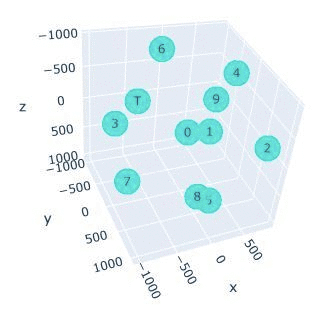